<a href="https://colab.research.google.com/github/yutaro-tanaka-yt2705/ag-cgan/blob/main/3_1_build_own_cgan_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import our common libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gzip
import sys
import warnings
import random

In [2]:
#Import our DL libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers, layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential, load_model, save_model, model_from_json
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import torch.cuda as cuda
import torch.nn as nn
import torch
from torch.distributions import Normal
######################################
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('Check GPU')

In [3]:
#Saving model
def save_mod(g, d, epo,folder='/content/drive/MyDrive/artificial_genome_project/cgan_models/'):
    discriminator.trainable = True
    save_model(g, folder+str(epo)+"_generator")
    save_model(d,folder+str(epo)+"_discriminator")

In [4]:
#Import our data
data = pd.read_csv('/content/drive/MyDrive/artificial_genome_project/test_dataset.csv')
data.head()

,ID,pair,X_1343510_CA_C,X_2464340_G_A,X_844565_T_G,X_1443587_C_T,X_846946_A_G,X_155783945_C_T,X_2348441_C_T,X_1495791_C_G,...,X_1494970_G_A,X_2272724_A_C,X_2441570_T_C,X_1420810_T_C,X_719380_A_G,X_1115457_A_G,X_2449045_T_C,X_1165297_A_G,population_code,suppop_code
0,HG00096,A,0,0,0,1,0,1,1,1,...,0,1,0,0,0,0,0,1,10.0,3.0
1,HG00096,B,0,0,1,1,1,1,0,1,...,0,1,0,0,0,1,0,0,10.0,3.0
2,HG00097,A,0,0,1,1,1,1,0,1,...,0,0,0,1,0,0,0,0,10.0,3.0
3,HG00097,B,0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,1,0,10.0,3.0
4,HG00099,A,0,0,1,1,1,1,0,0,...,0,1,1,1,0,0,1,0,10.0,3.0


In [6]:
var_data = data.iloc[:, 2:-2] #training data
#labels = keras.utils.to_categorical(data.population_code.tolist(), len(data.population_code.unique())) #training labels
labels = keras.utils.to_categorical(data.suppop_code.tolist(), len(data.suppop_code.unique())) #superpopulation labels
print(var_data.shape, labels.shape)

(5096, 1000) (5096, 5)


In [7]:
#Implement hyperparameters
class Hyperparameter:
    num_classes: int        = labels.shape[1]
    num_channels: int       = 1
    batchsize: int          = 16
    num_epochs: int         = 20
    latent_size: int        = 64
    n_critic: int           = 5
    critic_size: int        = 1024
    generator_size: int     = 1024
    critic_hidden_size: int = 1024
    gp_lambda: float        = 10.
    alpha: int              = 0.01
    d_lr: float             = 0.008
    g_lr: float             = 0.008
        
hp = Hyperparameter()

In [8]:
#Implement dataset
dataset = tf.data.Dataset.from_tensor_slices((var_data, labels))

In [9]:
for e in dataset:
  print(e[0].shape, e[1].shape)
  break

(1000,) (5,)


In [22]:
#Implement Generator
generator = Sequential(name='generator')
generator.add(keras.layers.InputLayer((hp.latent_size + hp.num_classes)))
generator.add(Dense(int(var_data.shape[1]//1.2), kernel_regularizer=regularizers.l2(0.0001)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=hp.alpha))
generator.add(Dense(int(var_data.shape[1]//1.1), kernel_regularizer=regularizers.l2(0.0001)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=hp.alpha))
generator.add(Dense(var_data.shape[1], activation = 'tanh'))
generator.build()

In [23]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 833)               58310     
                                                                 
 batch_normalization_4 (Batc  (None, 833)              3332      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 833)               0         
                                                                 
 dense_16 (Dense)            (None, 909)               758106    
                                                                 
 batch_normalization_5 (Batc  (None, 909)              3636      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 909)               0 

In [19]:
from keras import backend
#loss_func
def wasserstein_loss(true, pred):
  return backend.mean(true * pred)

#kernel_constraint
class DiscConstraint(keras.constraints.Constraint):
  def __init__(self, ref):
    self.ref = ref
  def __call__(self, weight):
    return backend.clip(weight, -self.ref, self.ref)
  def get_config(self):
    return {'ref_value': self.ref}

In [80]:
#Implement Discriminator
discriminator = Sequential(name='discriminator')
discriminator.add(keras.layers.InputLayer((1000, hp.num_channels + hp.num_classes)))

discriminator.add(Dense(var_data.shape[1]//2, kernel_constraint = DiscConstraint(0.01)))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(alpha=hp.alpha))
discriminator.add(Dense(var_data.shape[1]//3, kernel_constraint = DiscConstraint(0.01)))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(alpha=hp.alpha))
discriminator.add(Dense(1, activation = 'linear'))
opt = keras.optimizers.Adam(learning_rate=hp.d_lr)
discriminator.compile(optimizer=opt, loss=wasserstein_loss)
#Set discriminator to non-trainable
discriminator.trainable = False

In [81]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1000, 500)         3500      
                                                                 
 batch_normalization_6 (Batc  (None, 1000, 500)        2000      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 1000, 500)         0         
                                                                 
 dense_19 (Dense)            (None, 1000, 333)         166833    
                                                                 
 batch_normalization_7 (Batc  (None, 1000, 333)        1332      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 1000, 333)       

In [29]:
#Implement Conditional GAN
cgan = Sequential()
cgan.add(generator)
cgan.add(discriminator)
g_opt = keras.optimizers.Adam(learning_rate=hp.g_lr)
cgan.compile(optimizer=g_opt, loss=wasserstein_loss)

In [41]:
epoch = 200
batch_size = 32
batch = var_data.shape[0]//batch_size

loss_func = keras.losses.BinaryCrossentropy(from_logits=True)

d1_losses = []
d2_losses = []
g_losses = []

with tf.device('/device:GPU:0'):

  for e in range(epoch):
    for b in tqdm(range(batch)):
      
      #################
      #Make real samples
      #################
      random_pick = np.random.randint(0, var_data.shape[0], batch_size)
      #1. variant data
      var_data_real = var_data.iloc[random_pick] #batch data of variant data
      var_data_real = tf.cast(var_data_real, dtype=tf.float32) #make into float32 data (initially int64)
      var_data_real = tf.expand_dims(var_data_real, axis = -1) #add extra dimension
      
      #2. label data
      label_real = labels[random_pick] #batch data of label data
      real_one_hot_labels = label_real[:, None]
      real_one_hot_labels = tf.repeat(real_one_hot_labels, repeats=[1000])
      real_one_hot_labels = tf.reshape(
              real_one_hot_labels, (-1, 1000, hp.num_classes) #prepare labels to be concat with variant data.
              )
      real_one_hot_labels = tf.squeeze(real_one_hot_labels)

      #3. concat variant data with labels
      real_labelled_data = tf.concat([var_data_real, real_one_hot_labels], -1)

      #################
      #Make fake samples
      #################
      #4. prepare fake data
      latent_data = tf.random.normal(shape=(batch_size, hp.latent_size)) 
      latent_labelled_data = tf.concat([latent_data, label_real], axis=1)

      #5. generated fake data
      artificial_trained_data = generator.predict_on_batch(latent_labelled_data)
      artificial_trained_data = tf.expand_dims(artificial_trained_data, axis = -1)
      artificial_labelled_data = tf.concat([artificial_trained_data, real_one_hot_labels], axis=-1)

      #################
      #Train discriminator multiple times
      #################
      discriminator.trainable = True
      d1_loss_tmp, d2_loss_tmp = [], []
      for i in range(10):
          real, fake = -tf.ones((batch_size, 1)), tf.ones((batch_size, 1))
          dr_loss = discriminator.train_on_batch(real_labelled_data, real)
          df_loss = discriminator.train_on_batch(artificial_labelled_data, fake)
          d1_loss_tmp.append(dr_loss)
          d2_loss_tmp.append(df_loss)
      
      d1_losses.append(np.mean(d1_loss_tmp))
      d2_losses.append(np.mean(d2_loss_tmp))

      #################
      #Train whole GAN
      #################

      discriminator.trainable = False

      #Get latent space + misleading fake labels
      latent_data_gan = tf.random.normal(shape=(batch_size, hp.latent_size)) 
      latent_labelled_data_gan = tf.concat([latent_data_gan, label_real], axis=1)
      fake_misleading = -tf.ones((batch_size, 1))
      #train whole gan
      artificial_trained_data = generator.predict_on_batch(latent_labelled_data_gan)
      artificial_trained_data = tf.expand_dims(artificial_trained_data, axis = -1)
      artificial_labelled_data = tf.concat([artificial_trained_data, real_one_hot_labels], axis=-1)
      g_loss = discriminator.train_on_batch(artificial_labelled_data, fake_misleading)

      g_losses.append(g_loss)

    #save models at checkpoint
    if e+1 % 100 == 0 and e != 0:
      save_mod(generator, discriminator, str(e), folder='/content/drive/MyDrive/artificial_genome_project/cgan_models/string_models/')
    elif e == range(epoch):
      save_mod(generator, discriminator, str(e), folder='/content/drive/MyDrive/artificial_genome_project/cgan_models/string_models/')

100%|██████████| 159/159 [01:30<00:00,  1.76it/s]

INFO:tensorflow:Assets written to: /content/drive/MyDrive/artificial_genome_project/cgan_models/string_models/100_generator/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/artificial_genome_project/cgan_models/string_models/100_discriminator/assets


100%|██████████| 159/159 [01:30<00:00,  1.76it/s]


In [42]:
save_mod(generator, discriminator, str(e))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/artificial_genome_project/cgan_models/199_generator/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/artificial_genome_project/cgan_models/199_discriminator/assets


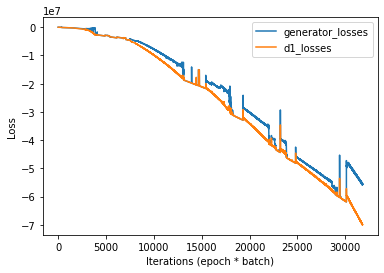

In [79]:
plt.plot(g_losses, label='generator_losses')
plt.plot(d1_losses, label='d1_losses')
plt.legend()
plt.xlabel('Iterations (epoch * batch)')
plt.ylabel('Loss')
plt.show()

---

In [ ]:
# create artificial genome dataset
generator_model_filepath = '/content/drive/MyDrive/artificial_genome_project/cgan_models/10_generator/'
generator = tf.keras.models.load_model(generator_model_filepath)

num_classes = hp.num_classes #num classes

# latent data
ag_num = 100
latent_samples = np.random.normal(loc=0, scale=1, size=(ag_num, hp.latent_size+hp.num_classes,))
generated_genomes = generator.predict(latent_samples)

for class_idx in range(num_classes):
    label = keras.utils.to_categorical([class_idx], num_classes)
    label = label[:, None]
    label = tf.repeat(label, repeats=[ag_num])
    label = tf.reshape(
            label, (-1, ag_num, hp.num_classes) #prepare labels to be concat with variant data.
            )
    label = tf.squeeze(label)
    label = tf.cast(label, tf.float32)

    latent_data = tf.random.normal(shape=(ag_num, hp.latent_size)) 
    latent_labels = tf.concat([latent_data, label], axis=1)

    artificial_data = generator.predict(latent_labels)
    artificial_data_df = pd.DataFrame(artificial_data)

    artificial_data_df.to_csv('/content/drive/MyDrive/artificial_genome_project/artificial_data/artificial_genome_'+str(class_idx)+'.csv', index=False)

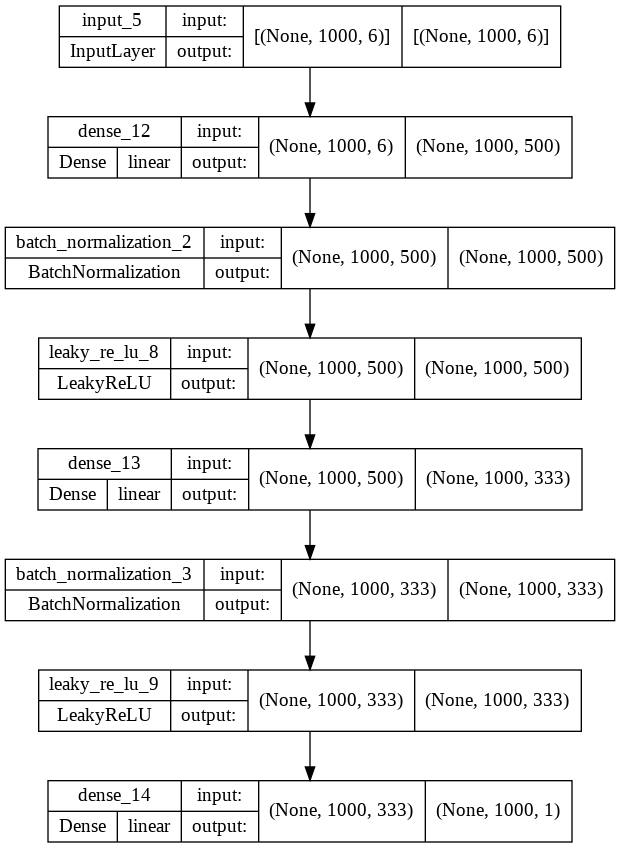

In [77]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_activations=True)

---